# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- $
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})$,
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [16]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math
from time import perf_counter

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


In [17]:
def plot_four(I1, I2, I3, I4, t1="Orginal", t2="", t3="", t4=""):
    fig, axs = plt.subplots(1, 4)
    n = 4
    fig.set_size_inches(4 * n, n)

    axs[0].imshow(I1, 'gray', vmin=0, vmax=256)
    axs[0].axis('off')
    axs[0].title.set_text(t1)

    axs[1].imshow(I2, 'gray', vmin=0, vmax=256)
    axs[1].axis('off')
    axs[1].title.set_text(t2)

    axs[2].imshow(I3, 'gray', vmin=0, vmax=256)
    axs[2].axis('off')
    axs[2].title.set_text(t3)

    axs[3].imshow(I4, 'gray', vmin=0, vmax=256)
    axs[3].axis('off')
    axs[3].title.set_text(t4)

def plot_with_diff(I1, I2, t1="Original", t2=''):
    fig, axs = plt.subplots(1, 3)
    n = 4
    fig.set_size_inches(3 * n, n)

    axs[0].imshow(I1, 'gray', vmin=0, vmax=256)
    axs[0].axis('off')
    axs[0].title.set_text(t1)

    axs[1].imshow(I2, 'gray', vmin=0, vmax=256)
    axs[1].axis('off')
    axs[1].title.set_text(t2)

    diff = np.abs(I1 - I2)
    axs[2].imshow(diff, 'gray')
    axs[2].axis('off')
    axs[2].title.set_text("Difference")

In [18]:
mat = loadmat('MR_data.mat')
I_noisefree = mat['I_noisefree']
I1 = mat['I_noisy1']
I2 = mat['I_noisy2']
I3 = mat['I_noisy3']
I4 = mat['I_noisy4']

In [19]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 

In [20]:
def gamma(y, var, alpha):
    return np.exp(-y*y / (alpha * var ** 2))

def new_value(window, filter, var, alpha):
    contex_size = filter.shape[0]
    size = window.shape[0]
    mid = size // 2
    pixel_contex = window[mid - contex_size//2 : mid + contex_size//2 + 1, mid - contex_size//2 : mid + contex_size//2 + 1]
    pixel_contex_g = pixel_contex * filter
    
    new_window = window.copy()

    for x in range(contex_size//2, size - contex_size//2):
        for y in range(contex_size//2, size - contex_size//2):
            contex = window[x - contex_size//2 : x + contex_size//2 + 1, y - contex_size//2 : y + contex_size//2 + 1]
            contex_g = contex * filter
            norm = np.sqrt(np.sum((pixel_contex_g - contex_g) ** 2))
            new_window[x, y] = gamma(norm, var, alpha)

    window = window[contex_size//2: size - contex_size//2, contex_size//2: size - contex_size//2]
    new_window = new_window[contex_size//2: size - contex_size//2, contex_size//2: size - contex_size//2]
    new_window = new_window / np.sum(new_window)
    val = np.sum(new_window * window)
    return int(val)

In [21]:
def nlm_filter(I, var, window_size=13, contex_size=3, sigma=3, alpha=3):
    filter = fgaussian(contex_size, sigma)
    I_copy = I.copy()
    width, height = I.shape
    r = window_size // 2
    for x in range(r, width - r):
        for y in range(r, height - r):
            window = I[x - r: x + r + 1, y - r: y + r + 1]
            I_copy[x, y] = new_value(window, filter, var, alpha)
    return I_copy

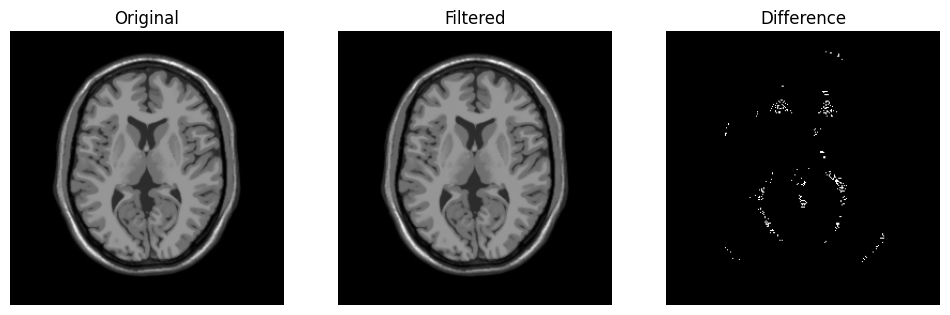

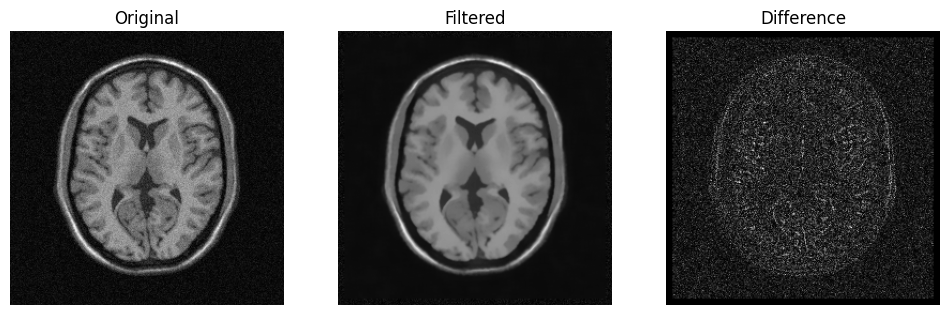

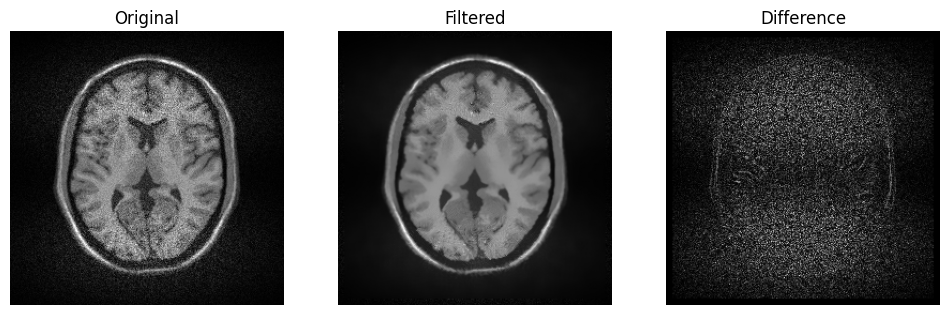

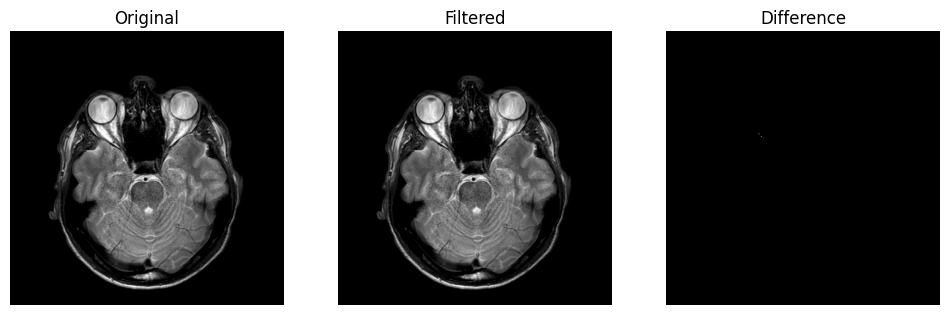

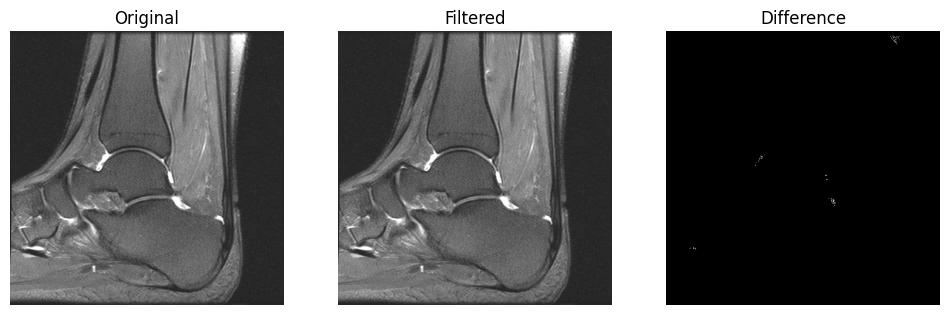

In [22]:
for img in [I_noisefree, I1, I2, I3, I4]:
    img_filtered = nlm_filter(img, var=5)
    plot_with_diff(img, img_filtered, t2=f"Filtered")
    plt.show()

In [23]:
def new_value_g(window, filter):
    val = np.sum(window * filter)
    return int(val)

def gaussian_convolution(I, size=5, sigma=0.5):
    filter = fgaussian(size, sigma)
    I_copy = I.copy()
    width, height = I.shape
    r = size // 2
    for x in range(r, width - r):
        for y in range(r, height - r):
            window = I[x - r: x + r + 1, y - r: y + r + 1]
            I_copy[x, y] = new_value_g(window, filter)
    return I_copy

In [24]:
def gamma_var(y_diff, var):
    return np.exp(-(y_diff ** 2) / (2 * var ** 2))

def new_value_var(window, filter, var):
    size = window.shape[0] // 2
    new_window = gamma_var(window[size, size] - window, var) * filter
    val = np.sum(new_window * window) / np.sum(new_window)
    return int(val)

def bilateral_filter(I, var, size=5, sigma=0.5):
    filter = fgaussian(size, sigma)
    I_copy = I.copy()
    width, height = I.shape
    r = size // 2
    for x in range(r, width - r):
        for y in range(r, height - r):
            window = I[x - r: x + r + 1, y - r: y + r + 1]
            I_copy[x, y] = new_value_var(window, filter, var)
    return I_copy

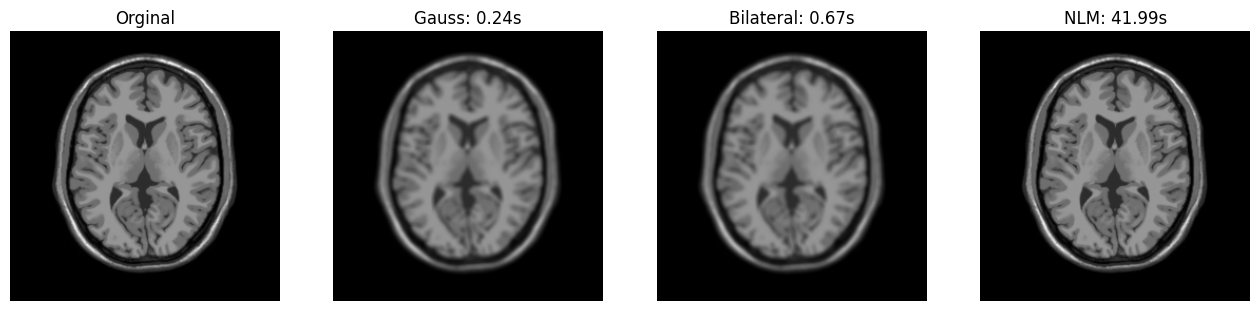

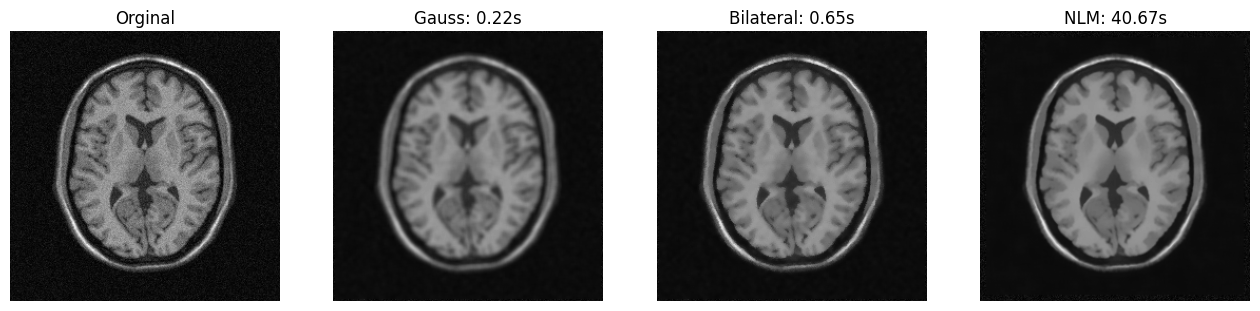

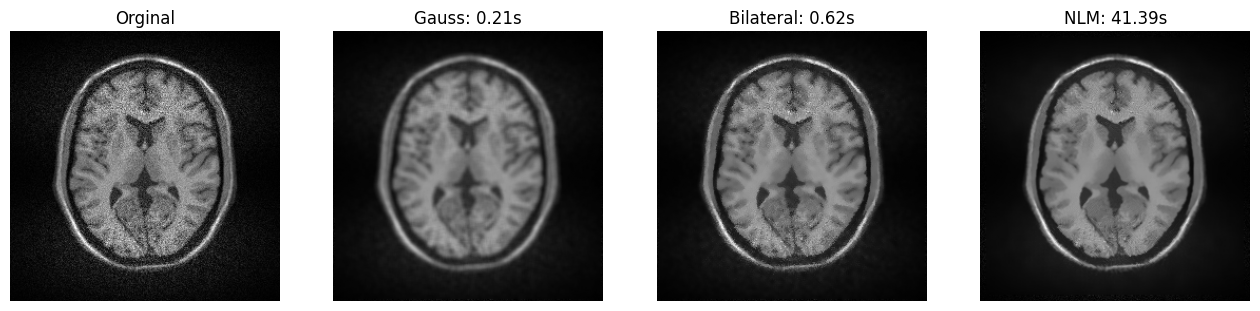

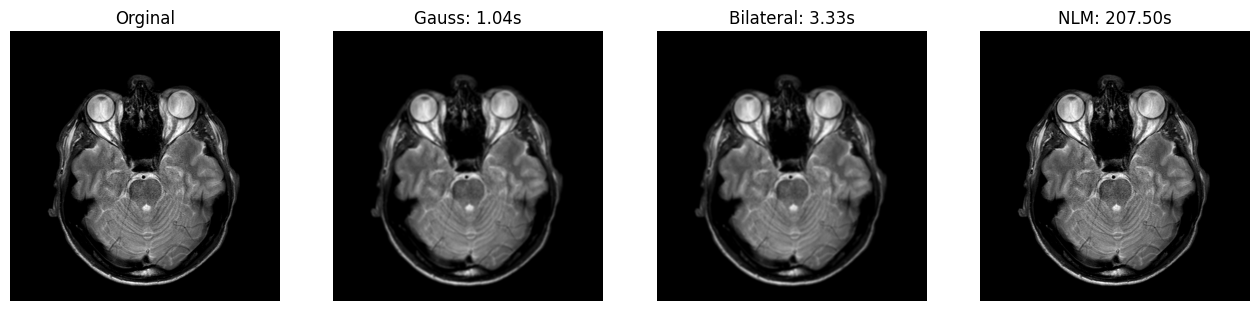

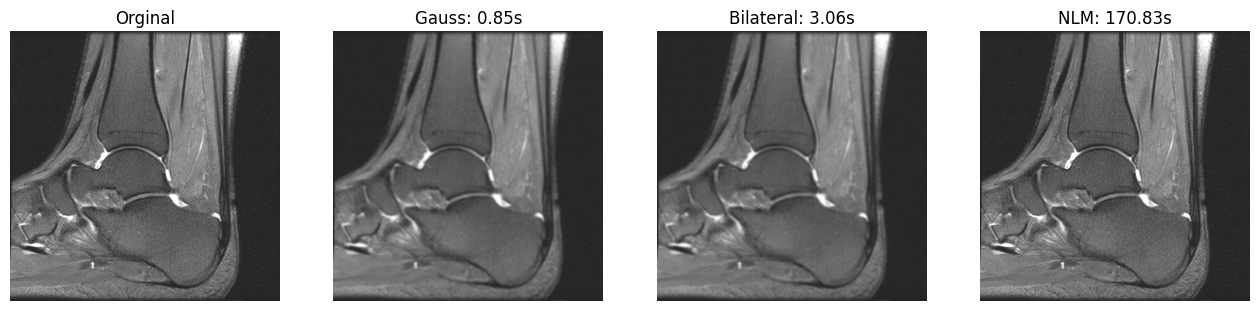

In [25]:
sigma = 3
var = 30
for i, img in enumerate([I_noisefree, I1, I2, I3, I4]):
    s1 = perf_counter()
    gauss = gaussian_convolution(img, 5, sigma)
    t1 = perf_counter() - s1

    s2 = perf_counter()
    bil = bilateral_filter(img, var, 5, sigma)
    t2 = perf_counter() - s2

    s3 = perf_counter()
    nlm = nlm_filter(img, 5, 13, 3, sigma)
    t3 = perf_counter() - s3

    plot_four(img, gauss, bil, nlm, t2=f"Gauss: {t1:.2f}s", t3=f"Bilateral: {t2:.2f}s", t4=f"NLM: {t3:.2f}s")
    

    plt.show()


#### Wyniki
Filtracja Gaussa powoduje znaczne rozmycie obrazu. Mniejsze rozmycie daje filtracja bilateralna, non-local means - najmniejsze rozmycie. WYkorzystanie algorytmu non-local means wpływa pozytywnie na jakość filtracji.

#### Czasy wykonania
Algorytm non-local means jest najbardziej wymagający obliczeniowo, czas wykonania filtracji tą metodą jest największy. Najszybciej wykonuje się filtracja Gaussa.